In [1]:
# === Patched Polar testbench (drop-in cell) ===
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# Utilities
# ----------------------------
def is_power_of_two(n):
    return (n & (n-1)) == 0 and n > 0

def bitrev_premutation(N):
    """Bit-reversal permutation (kept for reference; NOT used by canonical SC)."""
    if N == 1:
        return np.array([0], dtype=int)
    n = int(np.log2(N))
    br = np.empty(N, dtype=int)
    for i in range(N):
        b = format(i, '0{}b'.format(n))[::-1]
        br[i] = int(b, 2)
    return br

# ----------------------------
# Recursive polar transform (canonical natural-order)
# ----------------------------
def polar_transform(u):
    """Canonical recursive natural-order polar transform: x = F^{⊗n} * u (recursive).
    This is the same transform your current code uses (even/odd recursion)."""
    u = np.asarray(u, dtype=int)
    N = len(u)
    if N == 1:
        return u.copy().astype(np.int8)
    u_even = u[0:N:2]
    u_odd = u[1:N:2]
    upper = polar_transform((u_even ^ u_odd) % 2)
    lower = polar_transform(u_odd)
    return np.concatenate([upper, lower]).astype(np.int8)

# ----------------------------
# Bhattacharyya Z and frozen selection (direct canonical mapping)
# ----------------------------
def bhattacharyya_parameter(p, N):
    """Recursive Bhattacharyya parameters Z for BSC (length N)."""
    Z = np.array([2.0 * np.sqrt(p * (1.0 - p))])
    while len(Z) < N:
        Z_next = []
        for z in Z:
            Z_next.append(2*z - z*z)  # 'upper' channel Bhattacharyya
            Z_next.append(z*z)        # 'lower' channel Bhattacharyya
        Z = np.array(Z_next)
    return Z

def select_frozen_direct(N, K, p_design):
    """
    Select K best channels and create correct masks
    for BOTH canonical (decoder) and natural (encoder).
    """
    # logical Bhattacharyya values
    Z = bhattacharyya_parameter(p_design, N)
    logical_best = np.argsort(Z)[:K]     # logical indices 0..N-1

    # === MAP logical -> canonical order ===
    # canonical = bit-reversed ordering of logical indices
    br = bitrev_premutation(N)           # br[natural] = logical
    inv_br = np.argsort(br)              # inv_br[logical] = natural

    # canonical ordering is just logical ordering
    # SC decoder expects canonical positions
    info_positions_canonical = np.sort(logical_best)

    # === MAP canonical -> natural (for encoder & final extraction) ===
    info_positions_natural = np.sort(inv_br[info_positions_canonical])

    # build natural frozen mask (for encoder)
    frozen_mask_natural = np.ones(N, dtype=bool)
    frozen_mask_natural[info_positions_natural] = False

    # build canonical frozen mask (for decoder)
    frozen_mask_canonical = np.ones(N, dtype=bool)
    frozen_mask_canonical[info_positions_canonical] = False

    return (frozen_mask_natural, info_positions_natural,
            frozen_mask_canonical, info_positions_canonical)

# ----------------------------
# Channel, LLR helpers
# ----------------------------
def bsc(x, p):
    flips = (np.random.rand(len(x)) < p).astype(np.int8)
    return (x ^ flips).astype(np.int8)

def bsc_llr(y, p, eps=1e-12):
    # LLR for BSC (channel p). For BSC output y in {0,1}, LLR = log( P(y|0) / P(y|1) )
    p_safe = min(max(float(p), eps), 1.0 - eps)
    alpha = np.log((1.0 - p_safe) / p_safe)
    return (1 - 2*y) * alpha

# ----------------------------
# LLR combining (f,g) helpers
# ----------------------------
def f_min_sum(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    return np.sign(a * b) * np.minimum(np.abs(a), np.abs(b))

def f_exact(a, b, eps=1e-12):
    A = np.array(a, dtype=float)
    B = np.array(b, dtype=float)
    ta = np.tanh(A / 2.0)
    tb = np.tanh(B / 2.0)
    t = ta * tb
    t = np.clip(t, -1.0 + eps, 1.0 - eps)
    # 2*atanh(t) = log((1+t)/(1-t)) -> numerically via log1p
    return np.log1p(t) - np.log1p(-t)

# ----------------------------
# Canonical recursive SC decoder (returns uhat in canonical order)
# ----------------------------
def sc_decode(llr, frozen_mask, u_frozen=None, use_exact_f=False):
    """Successive Cancellation recursive decoder.
       - llr: length N (canonical order leaves)
       - frozen_mask: boolean mask in canonical order (same order as llr)
       - returns: uhat in canonical order
    """
    if u_frozen is None:
        u_frozen = np.zeros(len(frozen_mask), dtype=np.int8)
    llr = np.array(llr, dtype=float)
    frozen_mask = np.array(frozen_mask, dtype=bool)
    u_frozen = np.array(u_frozen, dtype=np.int8)

    def rec(llr_sub, frozen_sub, u_frozen_sub):
        n = len(llr_sub)
        if n == 1:
            if frozen_sub[0]:
                return np.array([u_frozen_sub[0]], dtype=np.int8)
            else:
                return np.array([0 if llr_sub[0] >= 0 else 1], dtype=np.int8)
        n2 = n // 2
        a = llr_sub[:n2]; b = llr_sub[n2:]
        f_llr = f_exact(a, b) if use_exact_f else f_min_sum(a, b)
        uhat_up = rec(f_llr, frozen_sub[:n2], u_frozen_sub[:n2])
        # stable g
        g_llr = b + ((-1) ** uhat_up) * a
        uhat_low = rec(g_llr, frozen_sub[n2:], u_frozen_sub[n2:])
        u_upper = (uhat_up ^ uhat_low).astype(np.int8)
        u_lower = uhat_low.astype(np.int8)
        return np.concatenate([u_upper, u_lower]).astype(np.int8)

    return rec(llr, frozen_mask, u_frozen)

# ----------------------------
# (Optional) reordering wrapper -- kept for reference but NOT used
# ----------------------------
def sc_decode_with_reordering(llr, frozen_mask_nat, u_frozen_nat=None, use_exact_f=False):
    """Wrapper that converts NATURAL-order inputs into tree order, calls sc_decode,
       then maps result back to NATURAL order. Kept for reference (not used)."""
    N = len(frozen_mask_nat)
    br = bitrev_premutation(N)        # natural -> bit-reversed mapping (index array)
    inv_br = np.argsort(br)           # bit-reversed -> natural
    frozen_mask_br = np.array(frozen_mask_nat, dtype=bool)[inv_br]
    if u_frozen_nat is None:
        u_frozen_nat = np.zeros(N, dtype=np.int8)
    u_frozen_br = np.array(u_frozen_nat, dtype=np.int8)[inv_br]
    uhat_br = sc_decode(llr, frozen_mask_br, u_frozen=u_frozen_br, use_exact_f=use_exact_f)
    uhat_nat = np.zeros_like(uhat_br)
    uhat_nat[br] = uhat_br
    return uhat_nat

def sc_natural_to_canonical(u_hat):
    N = len(u_hat)
    if N == 1:
        return u_hat.copy()
    
    n_half = N // 2
    up = sc_natural_to_canonical(u_hat[:n_half])
    low = sc_natural_to_canonical(u_hat[n_half:])

    out = np.empty(N, dtype=np.int8)
    out[0::2] = (up ^ low) & 1
    out[1::2] = low
    return out

# ----------------------------
# Deterministic self-check (canonical ordering)
# ----------------------------
def deterministic_debug_once(N=8, K=4, p_design=0.05, use_exact_f=True, verbose=True):
    """Deterministic no-noise check using the new select_frozen_direct that
    returns both natural & canonical masks/positions.
    Encoder uses NATURAL info positions.
    Decoder uses CANONICAL frozen mask.
    After SC decode (canonical), map decoded bits to natural for final extraction.
    """
    if not is_power_of_two(N):
        raise ValueError("N must be a power of two")

    # select_frozen_direct now returns four items:
    (frozen_mask_natural, info_positions_natural,
     frozen_mask_canonical, info_positions_canonical) = select_frozen_direct(N, K, p_design)

    u_frozen = np.zeros(N, dtype=np.int8)
    msg = np.random.randint(0,2,size=len(info_positions_natural)).astype(np.int8)

    # encoder (place message into NATURAL positions)
    u = np.zeros(N, dtype=np.int8)
    u[info_positions_natural] = msg
    x = polar_transform(u)

    # noiseless LLRs (very confident)
    llr = bsc_llr(x, p=1e-9)

    # SC decode: pass CANONICAL frozen mask (sc_decode returns canonical-order bits)
    u_hat_canonical = sc_decode(llr, frozen_mask_canonical, u_frozen=u_frozen, use_exact_f=use_exact_f)

    # Map decoded bits back to NATURAL order
    # (your helper sc_natural_to_canonical is used as the inverse mapping here;
    #  name is historically confusing but it performs canonical->natural mapping in your code)
    u_hat = sc_natural_to_canonical(u_hat_canonical)

    # final extraction uses NATURAL info positions
    msg_hat = u_hat[info_positions_natural]
    ok = np.array_equal(msg_hat, msg)

    if verbose:
        print("=== Deterministic Debug ===")
        print("N, K:", N, K)
        print("info_positions (natural):", info_positions_natural)
        print("info_positions (canonical):", info_positions_canonical)
        print("frozen_mask (natural):", frozen_mask_natural.astype(int))
        print("frozen_mask (canonical):", frozen_mask_canonical.astype(int))
        print("msg:", msg.tolist())
        print("u (full, natural):", u.tolist())
        print("x:", x.tolist())
        print("llr (sample 16):", llr[:16].tolist())
        print("u_hat (canonical):", u_hat_canonical.tolist())
        print("u_hat (natural):", u_hat.tolist())
        print("expected info (natural):", msg.tolist())
        print("decoded info (natural):", msg_hat.tolist())
        print("match?", ok)

    return ok

# ----------------------------
# Monte-Carlo (single N) - canonical ordering
# ----------------------------
def monte_carlo_polar_matrix(N=128, K=None, p_design=0.05, p_channel=None,
                             trials=200, use_exact_f=True, verbose=True):
    """
    Monte Carlo for a single N that uses the canonical frozen mask for decoding
    and the natural info positions for encoding / final extraction.
    """
    if not is_power_of_two(N):
        raise ValueError("N must be power of two")
    if K is None:
        K = N // 2
    if p_channel is None:
        p_channel = p_design

    (frozen_mask_natural, info_positions_natural,
     frozen_mask_canonical, info_positions_canonical) = select_frozen_direct(N, K, p_design)

    u_frozen = np.zeros(N, dtype=np.int8)
    K_actual = len(info_positions_natural)

    bit_err = 0
    block_err = 0
    for t in range(trials):
        msg = np.random.randint(0,2,size=K_actual).astype(np.int8)

        # encoder (natural positions)
        u = np.zeros(N, dtype=np.int8)
        u[info_positions_natural] = msg
        x = polar_transform(u)

        # channel + LLR (LLRs are naturally aligned with leaves)
        y = bsc(x, p_channel)
        llr = bsc_llr(y, p_channel)

        # DECODE: use canonical frozen mask (sc_decode returns canonical-order uhat)
        u_hat_canonical = sc_decode(llr, frozen_mask_canonical, u_frozen=u_frozen, use_exact_f=use_exact_f)

        # Map to natural ordering
        u_hat = sc_natural_to_canonical(u_hat_canonical)

        # Extract decoded message using NATURAL info positions
        msg_hat = u_hat[info_positions_natural]

        e = int(np.sum(msg_hat != msg))
        bit_err += e
        block_err += int(e > 0)

        if verbose and (t % max(1, trials//10) == 0):
            print(f"Trial {t}/{trials}: bit_err={bit_err}, block_err={block_err}")

    ber = bit_err / (trials * K_actual)
    bler = block_err / trials
    return ber, bler

# ----------------------------
# Monte-Carlo sweep and plotting helper
# ----------------------------
def monte_carlo_sweep_and_plot(N_list, K_ratio=0.5, p_design=0.05, p_channel=0.05,
                               trials=200, use_exact_f=True, verbose=False):
    """Run monte_carlo_polar_matrix for multiple N values, build a DataFrame and plot BER.
       - N_list: iterable of powers-of-two (e.g., [8,16,32,64,128])
       - K_ratio: fraction of N to use as K (e.g., 0.5)
    """
    rows = []
    for N in N_list:
        K = int(N * K_ratio)
        if verbose:
            print(f"Running N={N}, K={K}, p_ch={p_channel}")
        ber, bler = monte_carlo_polar_matrix(N=N, K=K, p_design=p_design, p_channel=p_channel,
                                             trials=trials, use_exact_f=use_exact_f, verbose=verbose)
        rows.append({"N": N, "K": K, "p": p_channel, "BER": ber, "BLER": bler})
    df = pd.DataFrame(rows).set_index("N")
    # Plot BER
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(df.index, df["BER"], marker="o", linestyle="-")
    ax.set_xscale("log", basex=2)
    ax.set_xticks(df.index)
    ax.set_xticklabels(df.index)
    ax.set_xlabel("N (block length)")
    ax.set_ylabel("BER")
    ax.set_title(f"Polar BER (p_channel={p_channel}, p_design={p_design})")
    ax.grid(True, which="both", ls="--", alpha=0.4)
    plt.show()
    return df

# ----------------------------
# Quick convenience test runner
# ----------------------------
def quick_sanity_and_plot():
    print("Run deterministic checks for a few N")
    for N in (4, 8, 16, 32):
        ok = deterministic_debug_once(N=N, K=N//2, p_design=0.01, use_exact_f=True, verbose=True)
        print("deterministic ok:", ok, "\n" + "-"*40)
    print("Now run a small sweep and plot (this may take some time)...")
    df = monte_carlo_sweep_and_plot([8,16,32,64], K_ratio=0.5, p_design=0.05, p_channel=0.05,
                                    trials=200, use_exact_f=True, verbose=False)
    print("\nResults DataFrame:")
    display(df)
    return df

# === End of patch ===


In [2]:
for _ in range(20):
    ok = deterministic_debug_once()
    if not ok:
        print("FAIL")
        break
else:
    print("ALL GOOD")


=== Deterministic Debug ===
N, K: 8 4
info_positions (natural): [3 5 6 7]
info_positions (canonical): [3 5 6 7]
frozen_mask (natural): [1 1 1 0 1 0 0 0]
frozen_mask (canonical): [1 1 1 0 1 0 0 0]
msg: [0, 1, 1, 0]
u (full, natural): [0, 0, 0, 0, 0, 1, 1, 0]
x: [0, 0, 1, 1, 1, 1, 0, 0]
llr (sample 16): [20.72326583594641, 20.72326583594641, -20.72326583594641, -20.72326583594641, -20.72326583594641, -20.72326583594641, 20.72326583594641, 20.72326583594641]
u_hat (canonical): [0, 0, 1, 1, 1, 1, 0, 0]
u_hat (natural): [0, 0, 0, 0, 0, 1, 1, 0]
expected info (natural): [0, 1, 1, 0]
decoded info (natural): [0, 1, 1, 0]
match? True
=== Deterministic Debug ===
N, K: 8 4
info_positions (natural): [3 5 6 7]
info_positions (canonical): [3 5 6 7]
frozen_mask (natural): [1 1 1 0 1 0 0 0]
frozen_mask (canonical): [1 1 1 0 1 0 0 0]
msg: [1, 1, 0, 1]
u (full, natural): [0, 0, 0, 1, 0, 1, 0, 1]
x: [1, 0, 0, 1, 1, 0, 0, 1]
llr (sample 16): [-20.72326583594641, 20.72326583594641, 20.72326583594641, -20.7

In [3]:
monte_carlo_polar_matrix()

Trial 0/200: bit_err=0, block_err=0
Trial 20/200: bit_err=78, block_err=4
Trial 40/200: bit_err=165, block_err=9
Trial 60/200: bit_err=173, block_err=10
Trial 80/200: bit_err=193, block_err=12
Trial 100/200: bit_err=207, block_err=14
Trial 120/200: bit_err=215, block_err=15
Trial 140/200: bit_err=239, block_err=19
Trial 160/200: bit_err=255, block_err=21
Trial 180/200: bit_err=267, block_err=23


(0.021796875, 0.125)

Testing different values of N for deterministic tests

In [4]:
for N in (16, 32, 64, 128):
    ok = True
    for _ in range(50):
        if not deterministic_debug_once(N=N, K=N//2, p_design=0.01, verbose=False):
            ok = False
            break
    print(N, "deterministic:", ok)


16 deterministic: True
32 deterministic: True
64 deterministic: True
128 deterministic: True


Testing N = 128 and K = 64 with different noise values

In [5]:
ps = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
for p in ps:
    ber, bler = monte_carlo_polar_matrix(
        N=128,
        K=64,
        p_channel=p,
        trials=2000,
        use_exact_f=True,
        verbose=False
    )
    print(f"p={p:0.3f}  BER={ber:0.4f}  BLER={bler:0.4f}")


p=0.010  BER=0.0001  BLER=0.0005
p=0.020  BER=0.0010  BLER=0.0050
p=0.050  BER=0.0168  BLER=0.0860
p=0.100  BER=0.1720  BLER=0.6200
p=0.150  BER=0.3634  BLER=0.9555
p=0.200  BER=0.4457  BLER=0.9985


In [6]:
for N in (64, 128, 256):
    ber, bler = monte_carlo_polar_matrix(
        N=N, K=N//2, p_channel=0.05,
        trials=2000, use_exact_f=True,
        verbose=False
    )
    print(N, ber, bler)


64 0.018109375 0.069
128 0.01721875 0.085
256 0.0106953125 0.0835


In [7]:
for K_ratio in (0.25, 0.5, 0.75):
    ber, bler = monte_carlo_polar_matrix(
        N=128, K=int(128*K_ratio), p_channel=0.05,
        trials=2000, use_exact_f=True, verbose=False
    )
    print(K_ratio, ber, bler)


0.25 0.0 0.0
0.5 0.014625 0.0795
0.75 0.24194791666666668 0.8055


Running N=64, K=32, p_ch=0.05
Trial 0/2000: bit_err=0, block_err=0
Trial 200/2000: bit_err=107, block_err=14
Trial 400/2000: bit_err=232, block_err=29
Trial 600/2000: bit_err=377, block_err=48
Trial 800/2000: bit_err=557, block_err=66
Trial 1000/2000: bit_err=646, block_err=81
Trial 1200/2000: bit_err=786, block_err=98
Trial 1400/2000: bit_err=941, block_err=114
Trial 1600/2000: bit_err=1012, block_err=123
Trial 1800/2000: bit_err=1165, block_err=139
Running N=128, K=64, p_ch=0.05
Trial 0/2000: bit_err=0, block_err=0
Trial 200/2000: bit_err=219, block_err=19
Trial 400/2000: bit_err=498, block_err=41
Trial 600/2000: bit_err=841, block_err=68
Trial 800/2000: bit_err=1100, block_err=91
Trial 1000/2000: bit_err=1364, block_err=109
Trial 1200/2000: bit_err=1521, block_err=122
Trial 1400/2000: bit_err=1701, block_err=137
Trial 1600/2000: bit_err=1952, block_err=157
Trial 1800/2000: bit_err=2146, block_err=175
Running N=256, K=128, p_ch=0.05
Trial 0/2000: bit_err=0, block_err=0
Trial 200/2000

TypeError: LogScale.__init__() got an unexpected keyword argument 'basex'

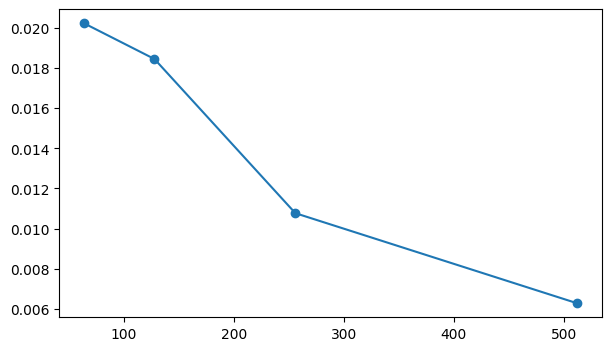

In [8]:
N_list = [64, 128, 256, 512]
monte_carlo_sweep_and_plot(N_list, K_ratio=0.5, p_design=0.05, p_channel=0.05,
                           trials=2000, use_exact_f=True, verbose=True)